The notebook is to explore different time-series forcasting method to predict the daily electricity prices in Australia. The dataset used is from https://www.kaggle.com/aramacus/electricity-demand-in-victoria-australia 
In the notebook, we will explore the methods of SARIMAX, Ensemble Forecaster, XGBoost, and also GRU to see which one is the most accurate.


In [1]:
!pip install sktime[all_extras]
!pip install matplotlib -U
!pip install xgboost -U

# Import Libraries

In [2]:
#Sktime library for ML
import sktime
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import EnsembleForecaster
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.bats import BATS
from sktime.forecasting.ets import AutoETS
from sktime.performance_metrics.forecasting import MeanSquaredError


#Traditional Time series model
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from fbprophet import Prophet

#XGBoost
from xgboost import XGBRegressor


#PyTorch
import torch
import torchvision  
import torch.nn.functional as F
import torchvision.transforms as transforms 
from torch import optim  
from torch import nn  
from torch.utils.data import TensorDataset,DataLoader
from sklearn.preprocessing import StandardScaler


import itertools
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,12)

In [3]:
df = pd.read_csv('/content/complete_dataset.csv')

#Set `Date` column to Datetime format and set it as Datetimeindex
df['Date'] = pd.to_datetime(df.date,infer_datetime_format=True)  
df = df.set_index('Date').asfreq('d')

#label encode school day and holiday column
df['school_day'] = df['school_day'].apply(lambda x: 0 if x == "N" else 1)
df['holiday'] = df['holiday'].apply(lambda x: 0 if x == "N" else 1)
df.dropna(inplace=True)

df

,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
Date,,,,,,,,,,,,,,
2015-01-01,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,0,1
2015-01-02,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,0,0
2015-01-03,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,0,0
2015-01-04,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,0,0
2015-01-05,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-02,2020-10-02,99585.835,-6.076028,41988.240,26.980251,57597.595,-30.173823,0.625000,12.8,26.0,22.0,0.0,0,0
2020-10-03,2020-10-03,92277.025,-1.983471,44133.510,32.438156,48143.515,-33.538025,0.583333,17.4,29.4,19.8,0.0,0,0
2020-10-04,2020-10-04,94081.565,25.008614,88580.995,26.571687,5500.570,-0.163066,0.062500,13.5,29.5,8.4,0.0,0,0


In [4]:
#Check null values and datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2102 entries, 2015-01-01 to 2020-10-06
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             2102 non-null   object 
 1   demand           2102 non-null   float64
 2   RRP              2102 non-null   float64
 3   demand_pos_RRP   2102 non-null   float64
 4   RRP_positive     2102 non-null   float64
 5   demand_neg_RRP   2102 non-null   float64
 6   RRP_negative     2102 non-null   float64
 7   frac_at_neg_RRP  2102 non-null   float64
 8   min_temperature  2102 non-null   float64
 9   max_temperature  2102 non-null   float64
 10  solar_exposure   2102 non-null   float64
 11  rainfall         2102 non-null   float64
 12  school_day       2102 non-null   int64  
 13  holiday          2102 non-null   int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 246.3+ KB


In [5]:
df.describe()

,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
count,2102.000000,2102.000000,2102.000000,2102.000000,2102.000000,2102.000000,2102.000000,2102.000000,2102.000000,2102.000000,2102.000000,2102.000000,2102.000000
mean,120036.408090,76.084873,119251.746306,76.560069,784.661784,-2.691163,0.008563,11.579924,20.415557,14.747526,1.505043,0.689343,0.036632
std,13747.235425,130.366950,14819.902317,130.234179,3582.162639,19.503619,0.039999,4.311288,6.289950,7.947423,4.308724,0.462873,0.187901
min,85094.375000,-6.076028,41988.240000,13.568986,0.000000,-342.220000,0.000000,0.600000,9.000000,0.700000,0.000000,0.000000,0.000000
25%,110011.593750,38.707040,109246.250000,39.117361,0.000000,0.000000,0.000000,8.500000,15.525000,8.200000,0.000000,0.000000,0.000000
50%,119605.242500,66.523630,119169.065000,66.853513,0.000000,0.000000,0.000000,11.300000,19.100000,12.750000,0.000000,1.000000,0.000000
75%,130436.006250,95.075012,130119.477500,95.130181,0.000000,0.000000,0.000000,14.600000,23.900000,20.775000,0.800000,1.000000,0.000000
max,170653.840000,4549.645105,170653.840000,4549.645105,57597.595000,0.000000,0.625000,28.000000,43.500000,33.300000,54.600000,1.000000,1.000000


In the dataframe, RRP is a recommended retail price in AUD$ / MWh, which is our target variable

In [6]:
#Set biweekly RRP as target
y = df.RRP.resample('SMS').mean()

#set time frequency to biweekly
time_freq_ts = 26
time_freq_ml = 365

# Check autocorrelation, seasonality, stationarity

**Seasonality**

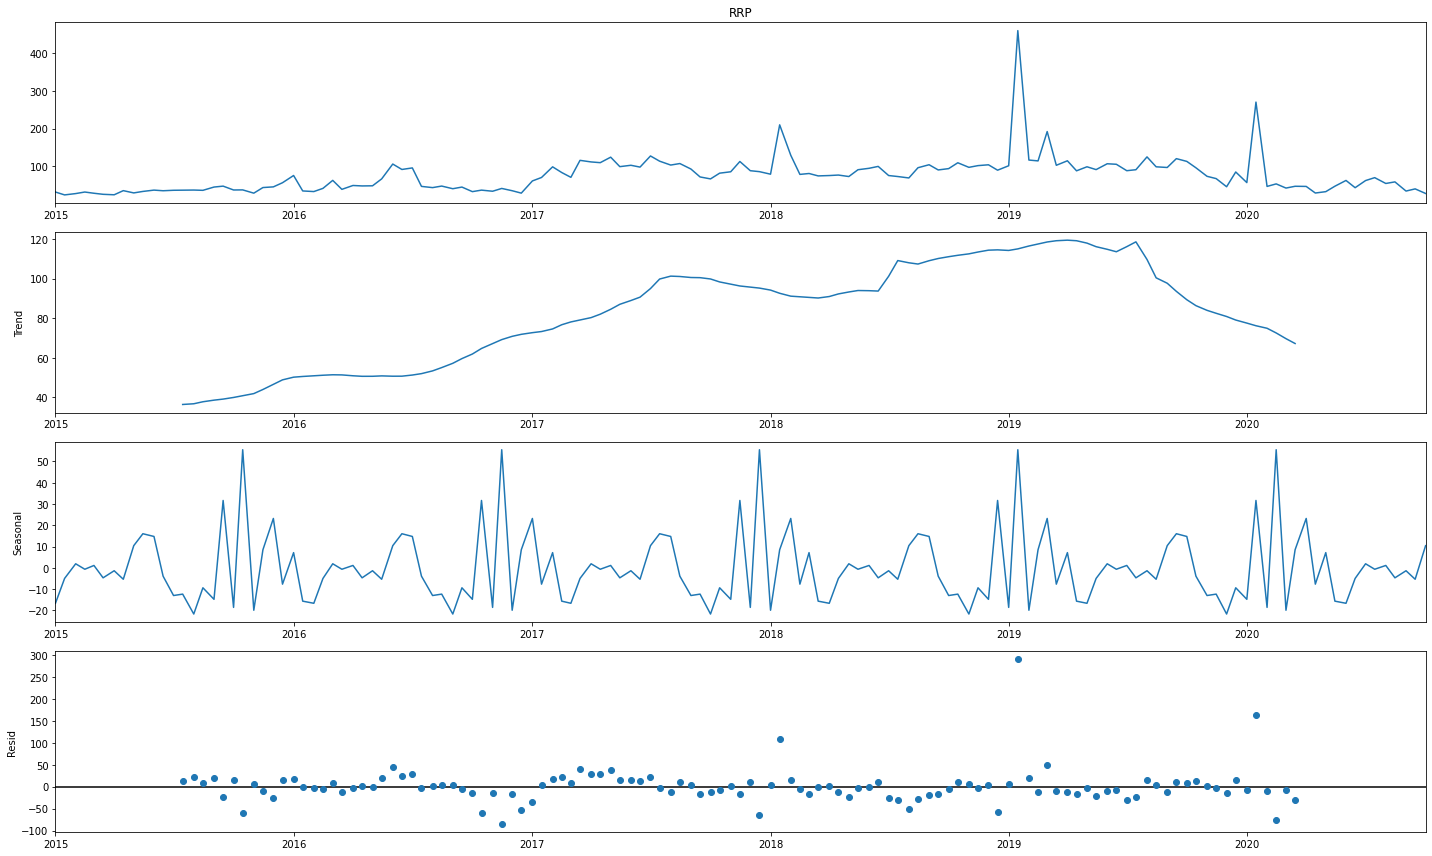

In [7]:
#Decompose on a monthly basis
decomposition = sm.tsa.seasonal_decompose(y, model='additive',period=time_freq_ts)
fig = decomposition.plot()
plt.show()

We can see
1. There is no clear trend
2. There is seasonality in the data
3. The residuals centre around 0.

We will now carry out ACF and PACF analysis

**ACF and PACF**

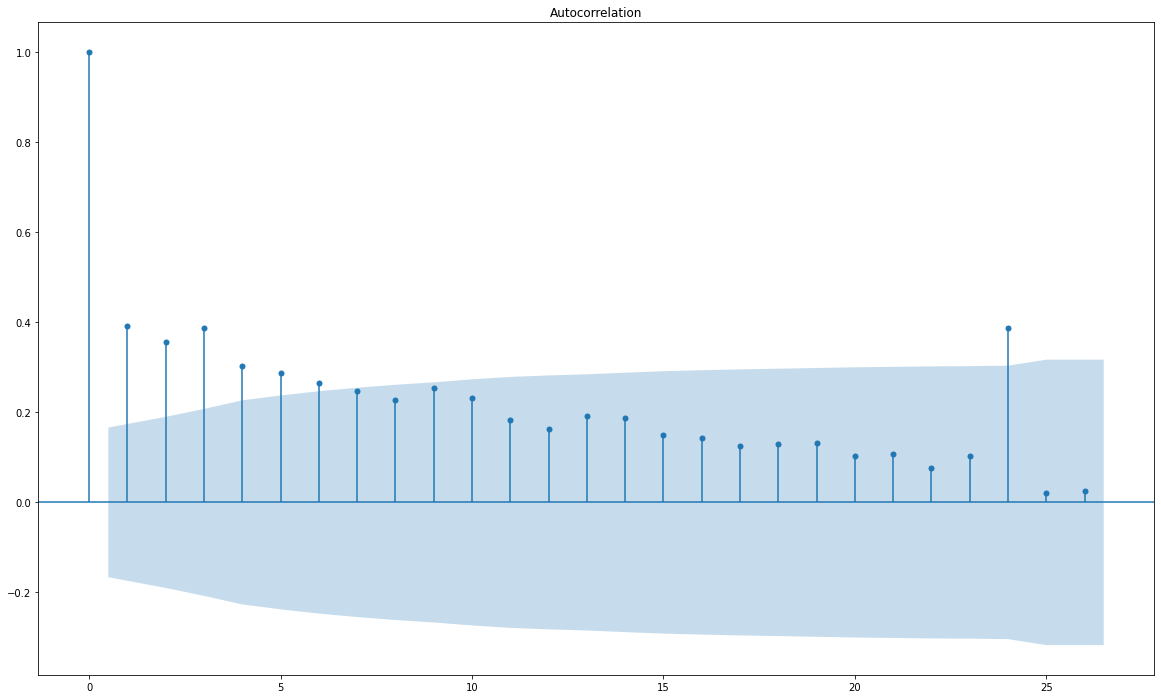

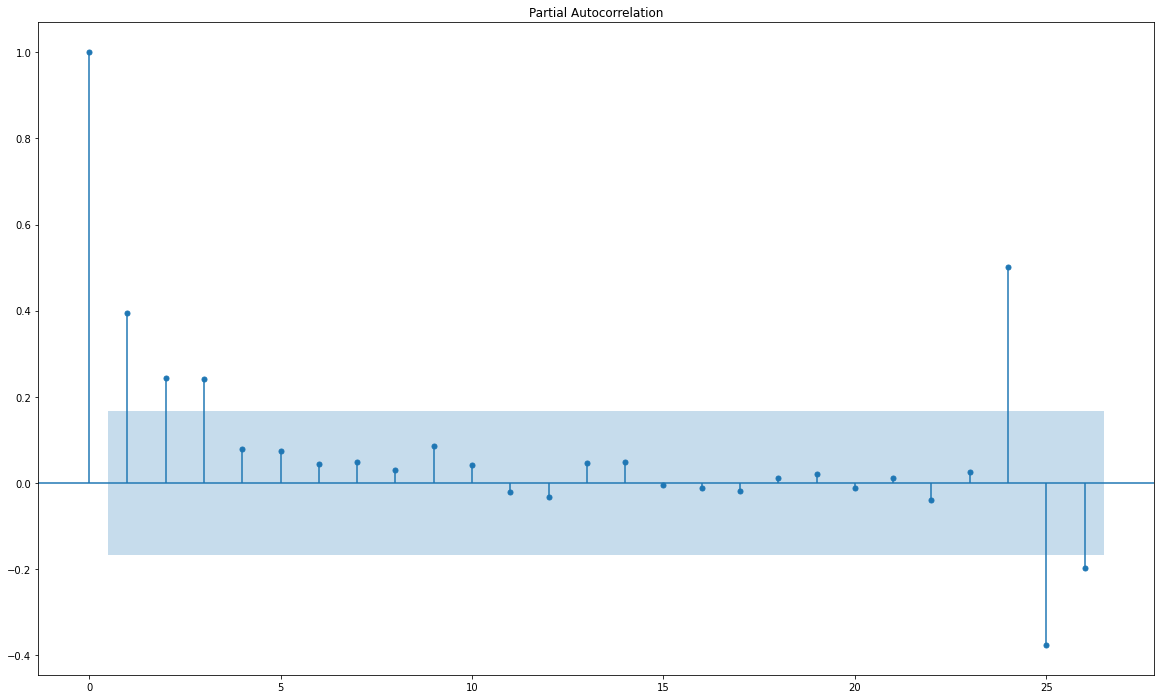

In [8]:
plot_acf(y.values.squeeze(), lags=time_freq_ts)
plot_pacf(y.values.squeeze(), lags=time_freq_ts)
plt.show()

We can see there is strong autocorrelation for first 4 lags in ACF and PACF, also lag 4 for PACF.

**Stationarity (Augmented Dickey-Fuller test)** 

In [9]:
print(adfuller(y))

(-3.5816373487346462, 0.006121943247408433, 2, 136, {'1%': -3.4793722137854926, '5%': -2.8830370378332995, '10%': -2.578233635380623}, 1303.8534332027987)


From ADF test, the p-value is 0.006. At 99% confidence interval, we can reject the null hypothesis and conclude that this time-series data is stationary. From the above we'll use SARIMA model for the time-series forecasting.

# Train test split
Now we will split our data to train and test data set, we will set y_test for 1 year for testing purpose

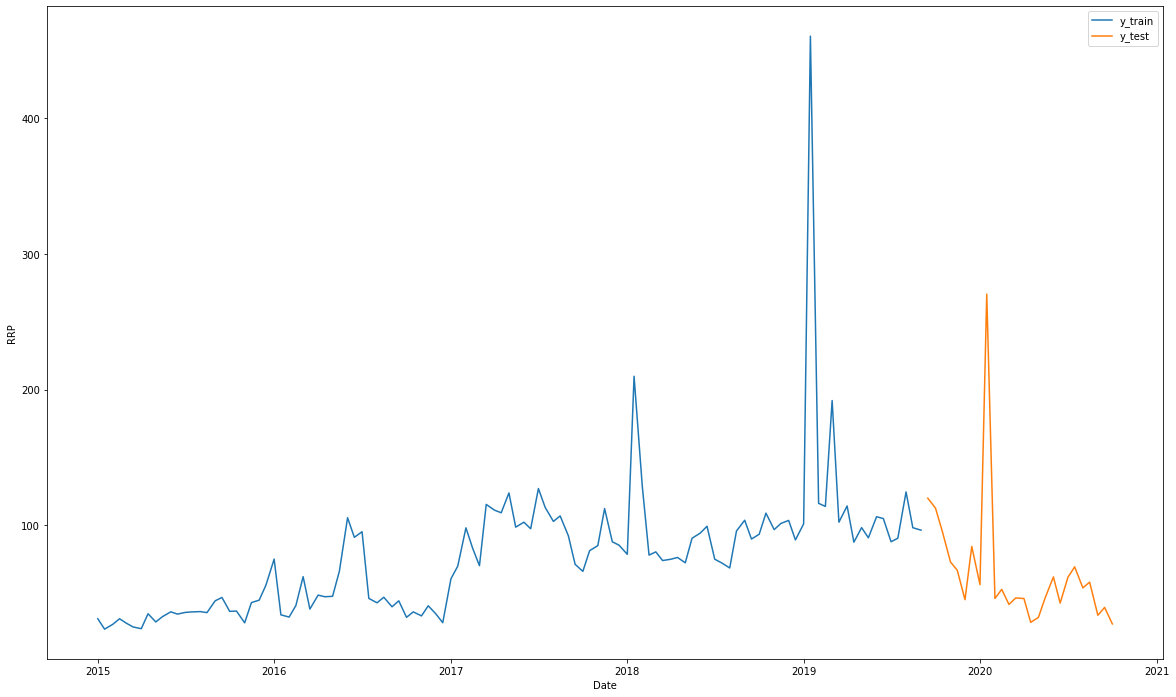

In [10]:
y_train = y[:-time_freq_ts]
y_test = y[-time_freq_ts:]

plt.plot(y_train,label='y_train')
plt.plot(y_test,label='y_test')
plt.xlabel('Date')
plt.ylabel('RRP')
plt.legend()

Given that there is seasonality and but stationarity in the data, we will use SARIMA model for the time-series forecasting. We will grid search the best parameters for the model with the lowest AIC in the following cell .

In [ ]:
# # Set the range of p,d,q
# p = range(0, 3)
# q = range(0, 5)
# d = [0]

# pdq = list(itertools.product(p, d, q))
# pdqs = [(x[0], x[1], x[2], time_freq) for x in list(itertools.product(p, d, q))]


# def sarimax_gridsearch(ts, pdq, pdqs, maxiter=50):
#     ans = []
#     for comb in tqdm(pdq):
#         for combs in pdqs:
#             try:
#                 mod = SARIMAX(ts,
#                               order=comb,
#                               seasonal_order=combs,
#                               enforce_stationarity=False,
#                               enforce_invertibility=False,
#                               )

#                 output = mod.fit(maxiter=maxiter, method="powell",disp=0) 
#                 ans.append([comb, combs, output.aic])
#             except:
#                 continue
                
#     ans.sort(key=lambda x: x[2])
#     order, seasonal_order = ans[0], ans[1]
#     print(f"Order: {order}, Seasonal_order: {seasonal_order}")
#     return order, seasonal_order

# sarimax_gridsearch(y, pdq, pdqs)


                                      SARIMAX Results                                      
Dep. Variable:                                 RRP   No. Observations:                  139
Model:             SARIMAX(2, 0, 1)x(2, 0, [], 26)   Log Likelihood                -457.249
Date:                             Fri, 13 Aug 2021   AIC                            926.497
Time:                                     02:56:57   BIC                            941.153
Sample:                                 01-01-2015   HQIC                           932.392
                                      - 10-01-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1023      0.152      7.271      0.000       0.805       1.399
ar.L2         -0.1091      

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



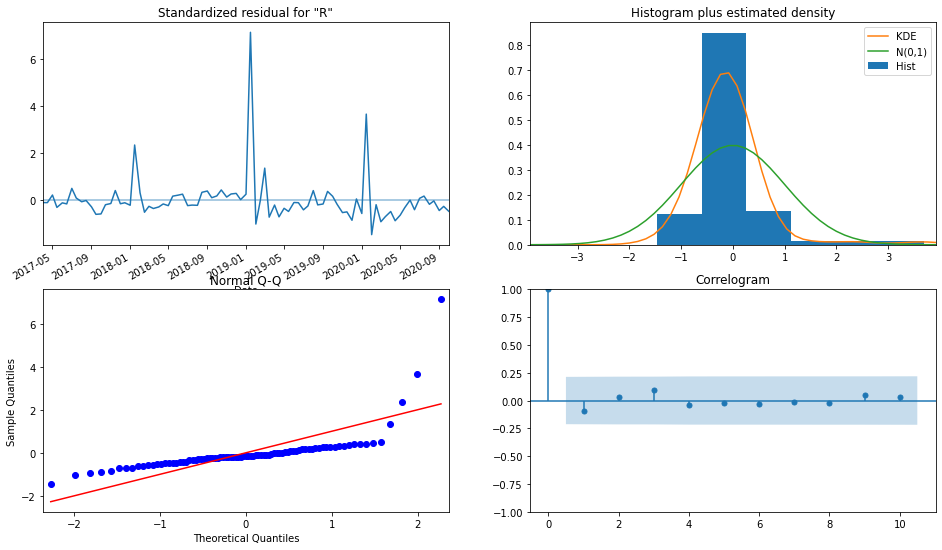

In [12]:
#Set the gridsearched output to model
sarimax = SARIMAX(y, 
                  order=(2, 0, 1), 
                  seasonal_order=(2, 0, 0, time_freq_ts), 
                  enforce_stationarity=False, 
                  enforce_invertibility=False)
                                    
# Fit the model
output = sarimax.fit(method="powell",disp=0)
    
# Print output summary
print(output.summary())

# Plot diagnostics
output.plot_diagnostics(figsize=(16,10))
plt.show()

In [13]:
#Create a function for plotting
def plot_forecast(y_test, y_pred, ci=None):
    plt.rcParams["figure.figsize"] = 20,9
    ax = y_test.plot(label='Observed')
    y_pred.plot(ax=ax, label='Forecast')
    try:
      ax.fill_between(ci.index,
                ci.iloc[:, 0],
                ci.iloc[:, 1], color='g', alpha=.25)
    except AttributeError:
      pass

    plt.xlabel('Date')
    plt.ylabel('RRP')
    plt.legend()
    plt.show()

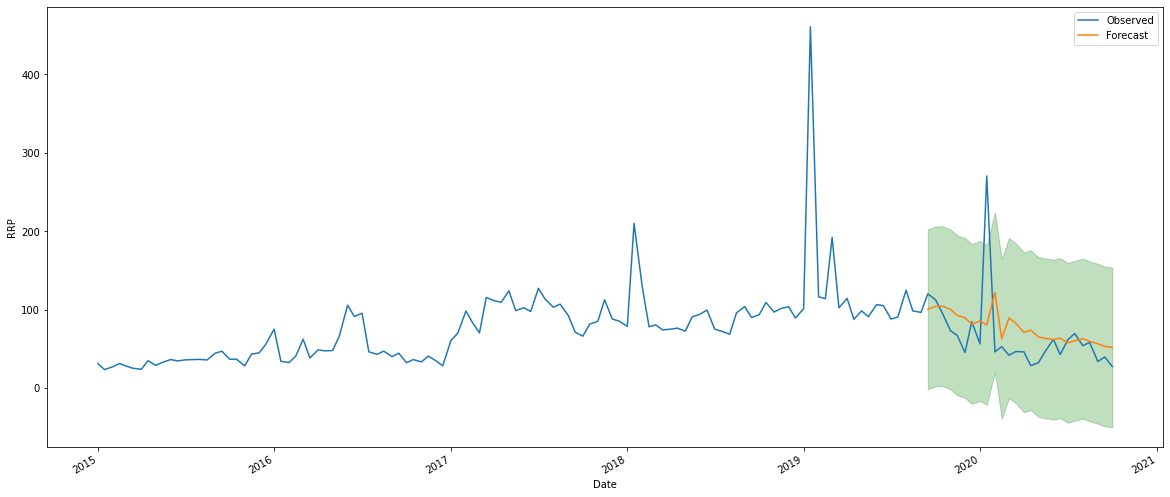

In [14]:
pred = output.get_prediction(start=-time_freq_ts, dynamic=False)
y_pred = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)
plot_forecast(y, y_pred, pred_ci)

**Forecast of SARIMA model**

And let's visualize the forecast of the RRP for 1 year after

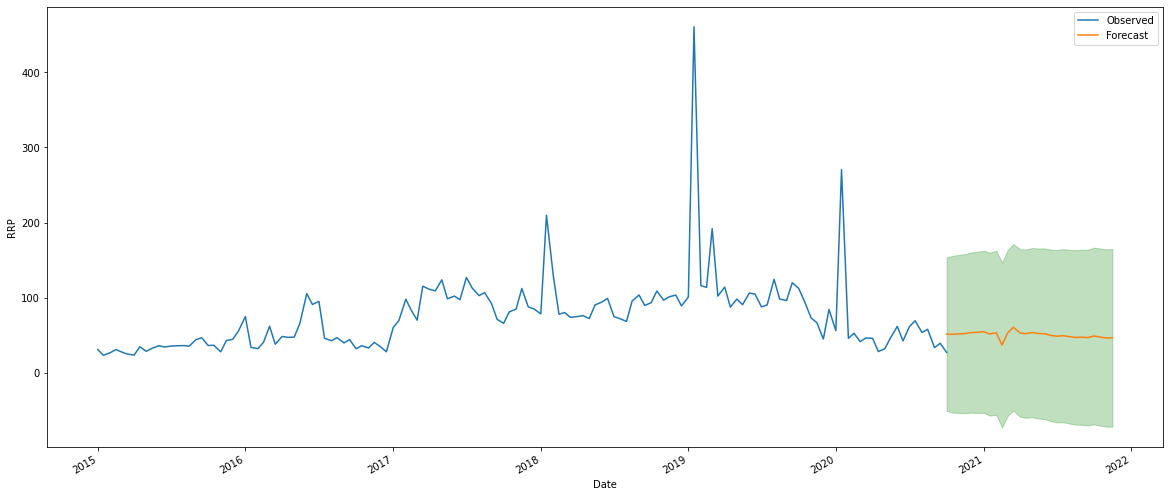

In [15]:
pred1 = output.get_prediction(start=-1 ,end = len(y)+time_freq_ts , dynamic=True)
y_forecast = pred1.predicted_mean
pred_ci1 = pred1.conf_int(alpha=0.05)
plot_forecast(y,y_forecast ,pred_ci1)

**MSE of SARIMA model**

In [16]:
mae_sarima = mean_absolute_error(y_test,y_pred)
print(f"The mean absolute error of SARIMA model is {mae_sarima}")

The mean absolute error of SARIMA model is 28.872520961950393


# Prophet
Now after using the traditional SARIMA model, Let's use Facebook's Prophet

In [17]:
#Convert our dataframe to prophet desired format
df_p = df.copy()
df_p.reset_index(inplace=True)
df_p = df_p[['Date','RRP']]
df_p.columns = ['ds','y']

#Split dataset
y_train_p = df_p.iloc[:-time_freq_ml,:]
y_test_p = df_p.iloc[-time_freq_ml:,:]

Then we'll create Prophet object and predict

In [18]:
#Create Prophet object
prophet = Prophet(daily_seasonality=True)
prophet.fit(y_train_p)
future = prophet.make_future_dataframe(periods=time_freq_ml)
prophet_pred = prophet.predict(future)
prophet_pred.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2097,2020-10-02,141.878159,-27.919794,282.584034,128.494160,155.227311,-19.444177,-19.444177,-19.444177,-13.036776,-13.036776,-13.036776,6.632623,6.632623,6.632623,-13.040024,-13.040024,-13.040024,0.0,0.0,0.0,122.433982
2098,2020-10-03,141.901748,-52.499720,256.674576,128.438049,155.316348,-39.680376,-39.680376,-39.680376,-13.036776,-13.036776,-13.036776,-13.098735,-13.098735,-13.098735,-13.544865,-13.544865,-13.544865,0.0,0.0,0.0,102.221372
2099,2020-10-04,141.925338,-54.996514,244.093669,128.403081,155.416559,-43.791420,-43.791420,-43.791420,-13.036776,-13.036776,-13.036776,-16.610171,-16.610171,-16.610171,-14.144472,-14.144472,-14.144472,0.0,0.0,0.0,98.133918
2100,2020-10-05,141.948927,-51.070828,265.407168,128.370208,155.516770,-31.400525,-31.400525,-31.400525,-13.036776,-13.036776,-13.036776,-3.537296,-3.537296,-3.537296,-14.826452,-14.826452,-14.826452,0.0,0.0,0.0,110.548402
2101,2020-10-06,141.972517,-30.337900,258.460425,128.332047,155.616981,-28.745445,-28.745445,-28.745445,-13.036776,-13.036776,-13.036776,-0.133989,-0.133989,-0.133989,-15.574680,-15.574680,-15.574680,0.0,0.0,0.0,113.227071


In [19]:
# Only extract the prediction for validation
y_pred_p = prophet_pred.iloc[-time_freq_ml:,[0,-1]]
y_pred_p = y_pred_p.set_index("ds").asfreq("D")

#Get ci for prediction as df for visualizing
pred_ci_p = prophet_pred.iloc[-time_freq_ml:,[0,2,3]]
pred_ci_p = pred_ci_p.set_index("ds").asfreq("D")

**Validation of Prophet model**

Let's validate our model with the test set.

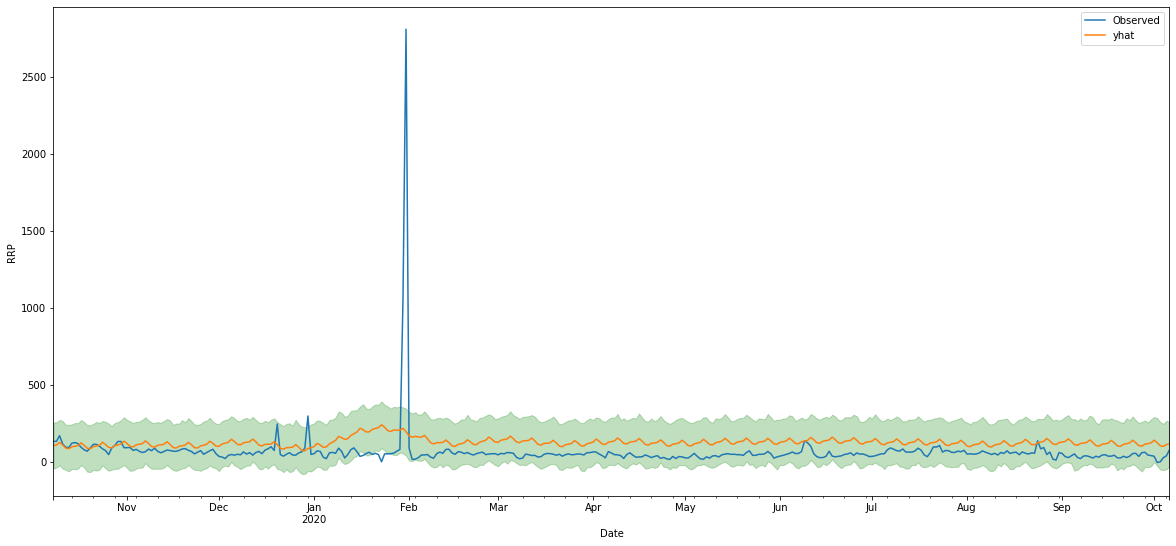

In [20]:
plot_forecast(df.RRP[-time_freq_ml:], y_pred_p, pred_ci_p)

**Forecast of Prophet model (Overall)**

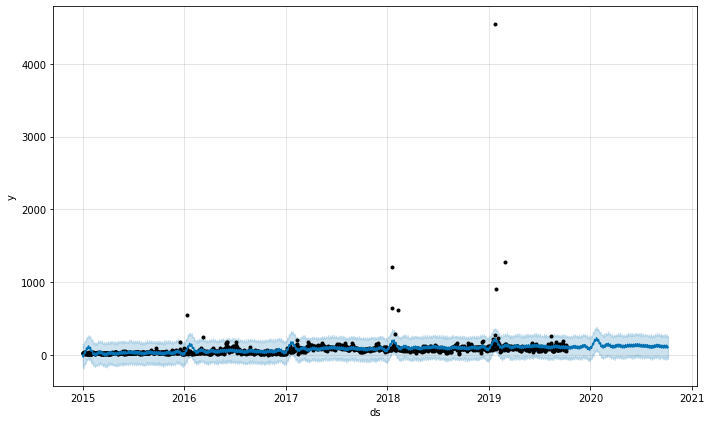

In [21]:
prophet.plot(prophet_pred)
plt.show()

**Forecast of Prophet model (components)**

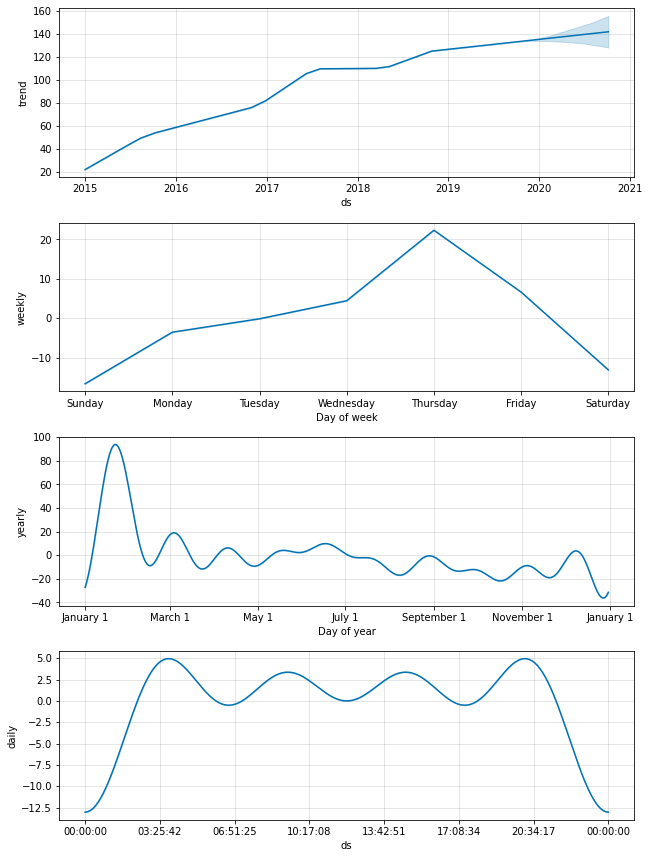

In [22]:
prophet.plot_components(prophet_pred)
plt.show()

**MAE of Prophet model**

In [23]:
mae_p = mean_absolute_error(y_test_p.y.values,y_pred_p.values)
print(f"The mean absolute error of Prophet model is {mae_p}")

The mean absolute error of Prophet model is 81.76171446124852


**Forecast with Prophet model for 1 year**

In [24]:
prophet1 = Prophet(daily_seasonality=True)
prophet1.fit(df_p)
future1 = prophet1.make_future_dataframe(periods=time_freq_ml)
prophet_pred1 = prophet.predict(future1)
y_pred_p1 = prophet_pred1.iloc[-time_freq_ml:,[0,-1]]
y_pred_p1 = y_pred_p1.set_index("ds").asfreq("D")

pred_ci_p1 = prophet_pred1.iloc[-time_freq_ml:,[0,2,3]]
pred_ci_p1 = pred_ci_p1.set_index("ds").asfreq("D")

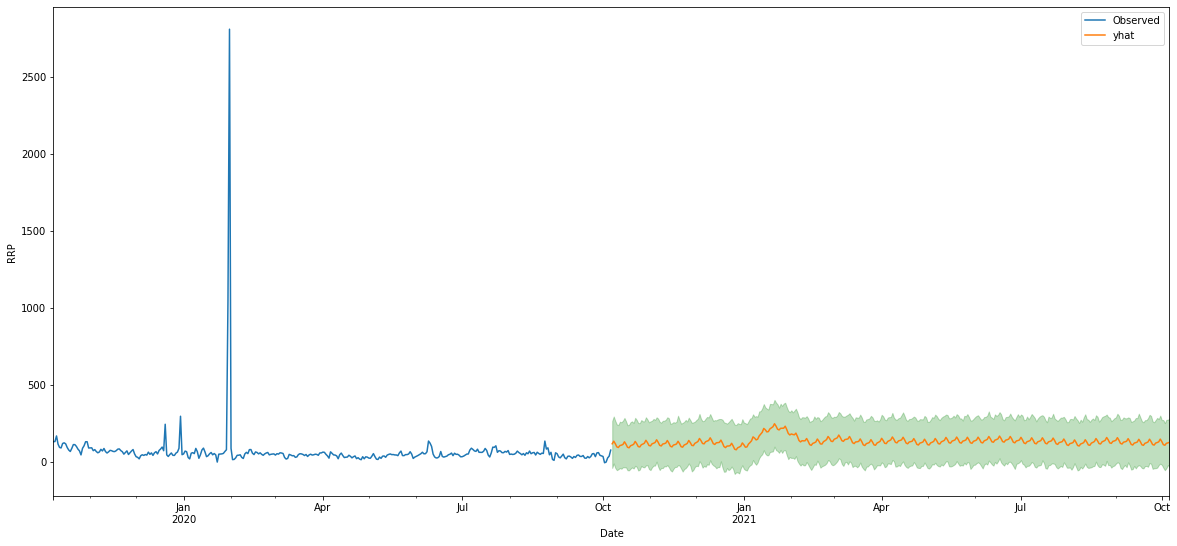

In [25]:
plot_forecast(df.RRP[-time_freq_ml:],y_pred_p1,pred_ci_p1)

# Machine Learning - Ensemble Forecaster

Sktime is a powerful library which allows you to do time-series forecasting easily. This time we will use ensemble forecaster to ensemble different algorithms - NaiveForecaster, BATS, AutoETS, PolynomialTrendForecaster

**EnsembleForecaster**

In [30]:
#Set y_train and y_test into daily frequency to fit into ML algos
y_train_m = y_train_p.set_index("ds").asfreq("D")
y_test_m = y_test_p.set_index("ds").asfreq("D")
y_train_m = y_train_m['y']
y_test_m = y_test_m['y']

In [ ]:
fh = ForecastingHorizon(y_test_m.index, is_relative=False)
forecasters = [("naive", NaiveForecaster(strategy="last", sp=365)),
               ("AETS", AutoETS(auto=True, sp=365),
               ("BATS", BATS(sp=365)),
                ("PTF",PolynomialTrendForecaster())
               )]
forecaster = EnsembleForecaster(forecasters)

forecaster.fit(y_train_m)

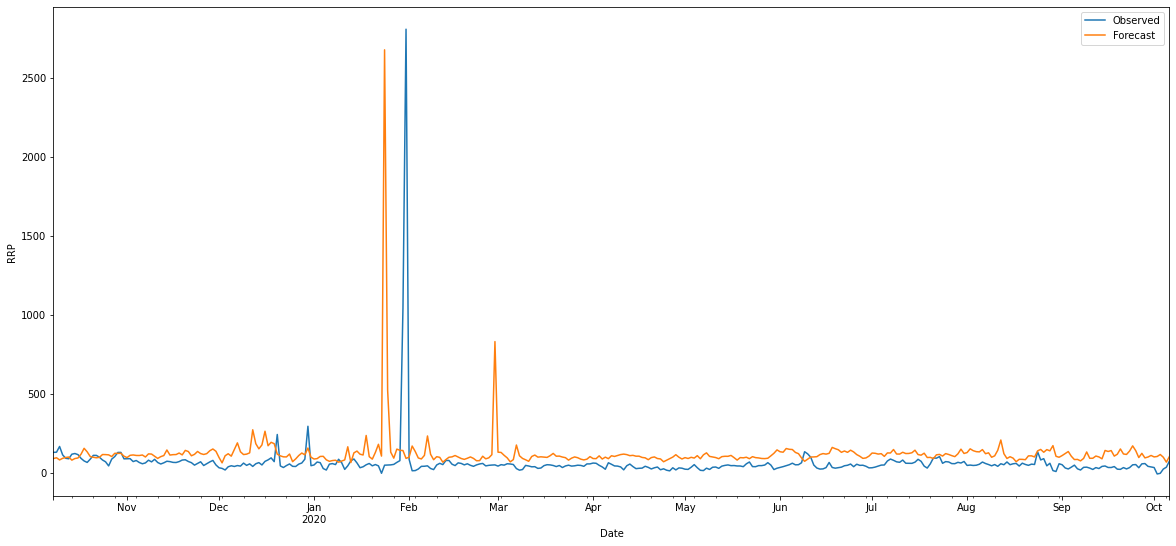

In [ ]:
#Make forecast for 1 year
y_pred_m = forecaster.predict(fh=fh)

#plot validation
plot_forecast(df.RRP[-365:],y_pred_m)

**MAE of EnsembleForecaster**

In [ ]:
mse_m = mean_absolute_error(y_test_m.values,y_pred_m.values)
print(f"The mean absolute error of EnsemblerForecaster model is {mse_m}")

The mean absolute error of EnsemblerForecaster model is 82.41727788315444


# Machine Learning - XGBoost

**Univariate time-series forecasting**

In [26]:
#Create a function for creating training and test dataset, here we set up a paramenter exo to set if we want to include other exogenous variables to do multivariate Time series regression
def create_features(df, label=None, exo=False):

    df1 = df.copy()

    df1['date'] = df1.index
    df1['dayofweek'] = df1['date'].dt.dayofweek
    df1['quarter'] = df1['date'].dt.quarter
    df1['month'] = df1['date'].dt.month
    df1['year'] = df1['date'].dt.year
    df1['dayofyear'] = df1['date'].dt.dayofyear
    df1['dayofmonth'] = df1['date'].dt.day
    df1['weekofyear'] = df1['date'].dt.weekofyear
    df1.pop('date')
    
    if exo == False:
      X = df1.loc[:,['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
      y = df1[label]
    else:
      y = df1.pop(label)
      X = df1

    return X, y

In [27]:
X_train_xgb, y_train_xgb = create_features(df.iloc[:-time_freq_ml,:], label="RRP")
X_test_xgb, y_test_xgb = create_features(df.iloc[-time_freq_ml:,:], label="RRP")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [28]:
XBGreg = XGBRegressor(n_estimators=1000)
XBGreg.fit(X_train_xgb, y_train_xgb,eval_set=[(X_train_xgb, y_train_xgb), (X_test_xgb, y_test_xgb)],verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=2, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

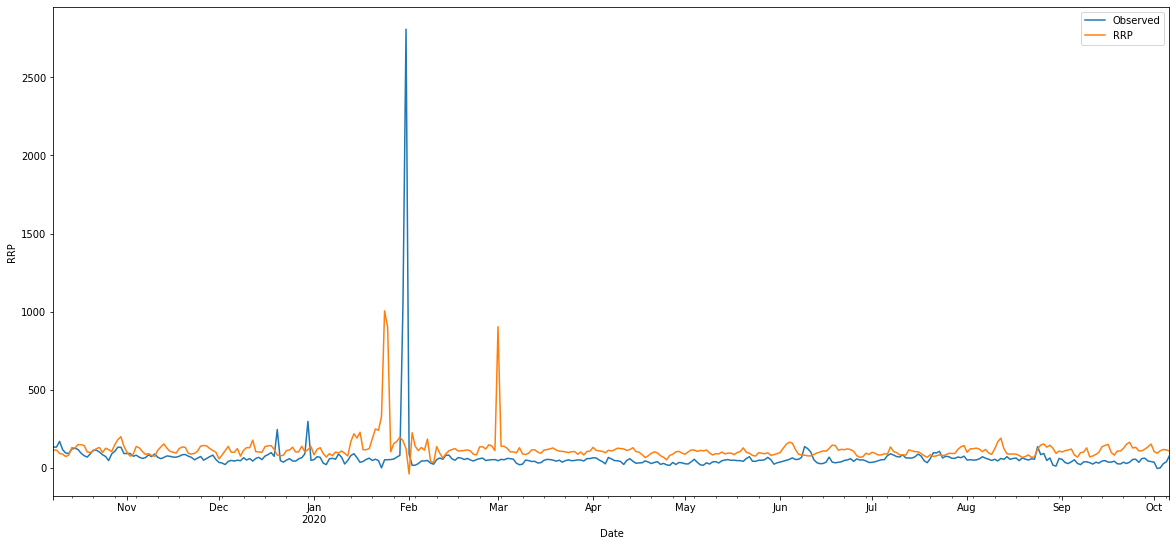

In [31]:
y_pred_xgb = XBGreg.predict(X_test_xgb)
y_pred_xgb = pd.DataFrame(y_pred_xgb,index=y_pred_p.index, columns=['RRP'])
plot_forecast(y_test_m, y_pred_xgb)

**Mean absolute error of XGBoost model (univariate model)**

In [32]:
mae_xgb = mean_absolute_error(y_test_p.y.values,y_pred_xgb.values)
print(f"The mean absolute error of XGBoost univariate model is {mae_xgb}")

The mean absolute error of XGBoost univariate model is 74.64114619246756


**Multivariate model**
After trying the modelling with univariate time series, we will use other exogenous variables to do multivariate time-series

In [33]:
X_train_xgb1, y_train_xgb1 = create_features(df.iloc[:-time_freq_ml,:], label="RRP",exo=True)
X_test_xgb1, y_test_xgb1 = create_features(df.iloc[-time_freq_ml:,:], label="RRP", exo=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



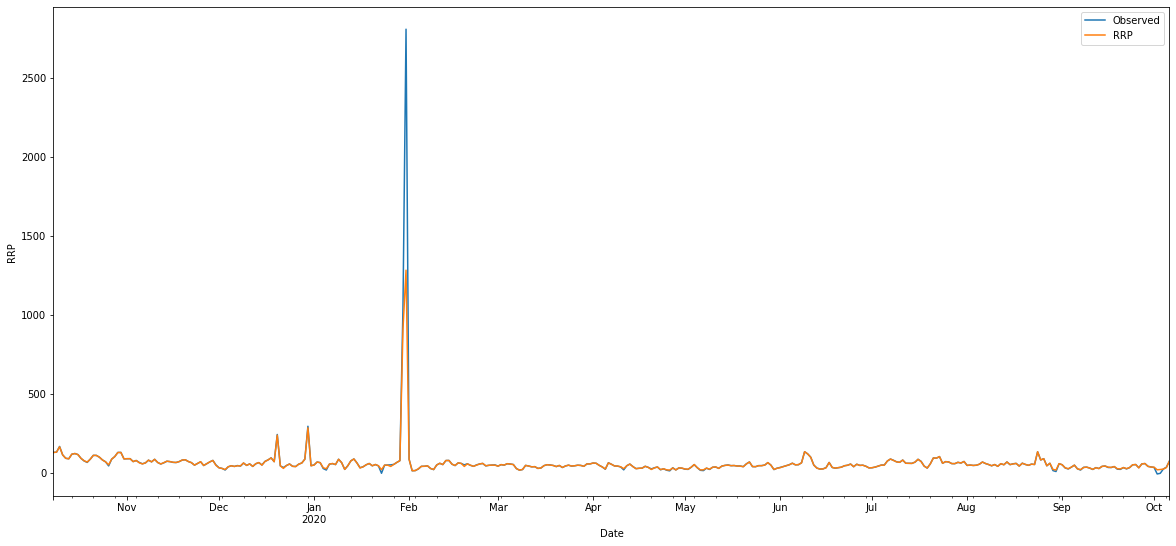

In [34]:
XBGreg.fit(X_train_xgb1, y_train_xgb1,eval_set=[(X_train_xgb1, y_train_xgb1), (X_test_xgb1, y_test_xgb1)],verbose=False)
y_pred_xgb1 = XBGreg.predict(X_test_xgb1)
y_pred_xgb1 = pd.DataFrame(y_pred_xgb1,index=y_pred_p.index, columns=['RRP'])
plot_forecast(y_test_m, y_pred_xgb1)

**Mean absolute error of XGBoost model (multivariate model)**

In [36]:
mae_xgb1 = mean_absolute_error(y_test_xgb1.values,y_pred_xgb1.values)
print(f"The mean absolute error of XGBoost multivariate model is {mae_xgb1}")

The mean absolute error of XGBoost multivariate model is 5.440377183315439


The multivariable model almost matches the whole trend in the series!

# GRU model by Pytorch

Finally let's try to model the data using GRU in PyTorch, we will do a multivariate time series model. Reference from: https://towardsdatascience.com/building-rnn-lstm-and-gru-for-time-series-using-pytorch-a46e5b094e7b

In [38]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
input_dim = X_train_xgb1.shape[1]
output_dim = 1
hidden_dim = 256
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 100
learning_rate = 1e-4
weight_decay = 1e-6

In [42]:
# Create a function to load the train and test set into PyTorch's dataloader
def create_dl(df, period, train=True, batch_size=batch_size, exo=True):
    #Create new train and test dataset
    X_train, y_train = create_features(df.iloc[:-period,:], label="RRP", exo=exo)
    X_test, y_test = create_features(df.iloc[-period:,:], label="RRP", exo=exo)
    y_train = y_train.values.reshape(-1, 1)
    y_test = y_test.values.reshape(-1, 1)
    
    #Standardize the data
    sc = StandardScaler()
    label_sc = StandardScaler()
    sc.fit(X_train)
    label_sc.fit(y_train)
    if train == True:
        X_sc = sc.transform(X_train.values)
        y_sc = label_sc.transform(y_train)
    else:
        X_sc = sc.transform(X_test.values)
        y_sc = label_sc.transform(y_test)

    
    #Convert to Tensors
    X_sc = X_sc.astype(np.float32)
    y_sc = y_sc.astype(np.float32)
    X_tensor = torch.from_numpy(X_sc)
    y_tensor = torch.from_numpy(y_sc)
    
    
    print("X's shape:",X_tensor.shape)
    print("Y's shape:",y_tensor.shape)

  #Create Dataset using the tensors and put it the Pytorch Dataloader
    ds = TensorDataset(X_tensor, y_tensor)
    dl = DataLoader(dataset=ds, batch_size=batch_size,shuffle=False, 
#                     drop_last=True
                   )
    
    
    return dl


train_loader = create_dl(df,time_freq_ml,train=True,batch_size=batch_size)
test_loader = create_dl(df,time_freq_ml,train=False,batch_size=batch_size)

X's shape: torch.Size([1737, 19])
Y's shape: torch.Size([1737, 1])
X's shape: torch.Size([365, 19])
Y's shape: torch.Size([365, 1])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [43]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        self.gru.flatten_parameters()
        
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [44]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
    
    def train_step(self, x, y):
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()
    
    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.unsqueeze(1).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.unsqueeze(1).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)
                
            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

    def evaluate(self, test_loader, batch_size=1, n_features=1):
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.unsqueeze(1).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.to(device).detach().numpy())
                values.append(y_test.to(device).detach().numpy())

        return predictions, values
    
    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

**Training of our GRU model**

[1/100] Training loss: 0.9753	 Validation loss: 1.5008
[2/100] Training loss: 0.9561	 Validation loss: 1.4752
[3/100] Training loss: 0.9376	 Validation loss: 1.4419
[4/100] Training loss: 0.9164	 Validation loss: 1.3990
[5/100] Training loss: 0.8781	 Validation loss: 1.3475
[6/100] Training loss: 0.8349	 Validation loss: 1.2921
[7/100] Training loss: 0.7886	 Validation loss: 1.2384
[8/100] Training loss: 0.7342	 Validation loss: 1.1898
[9/100] Training loss: 0.6874	 Validation loss: 1.1471
[10/100] Training loss: 0.6321	 Validation loss: 1.0941
[50/100] Training loss: 0.2489	 Validation loss: 0.1484
[100/100] Training loss: 0.1347	 Validation loss: 0.0221


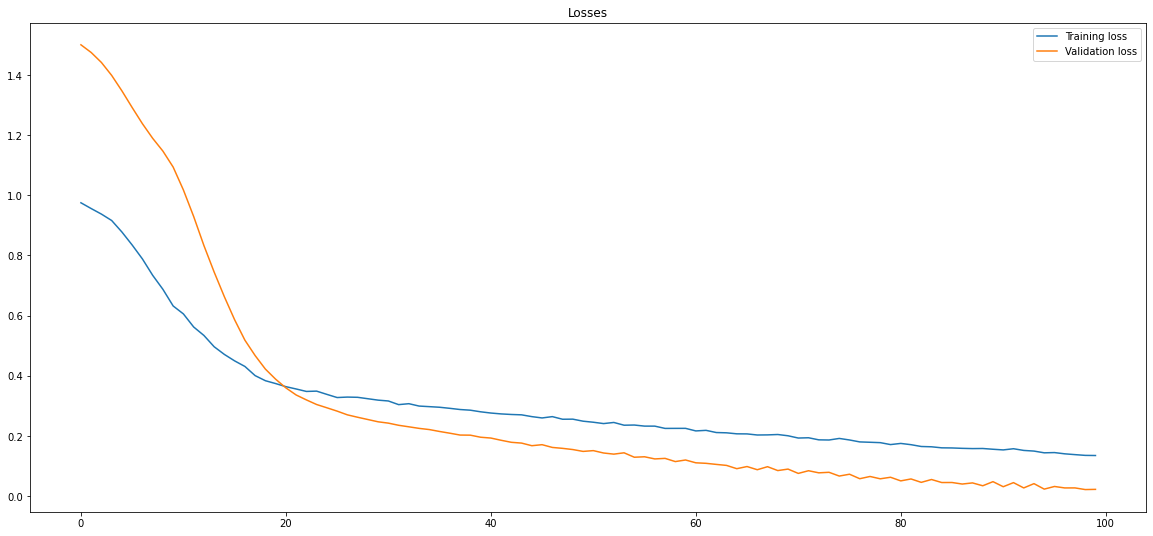

In [45]:
model = GRUModel(input_dim,hidden_dim,layer_dim,output_dim,dropout)
loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, test_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(test_loader, batch_size=1, n_features=input_dim)

**Validation and Visualization of the GRU model**

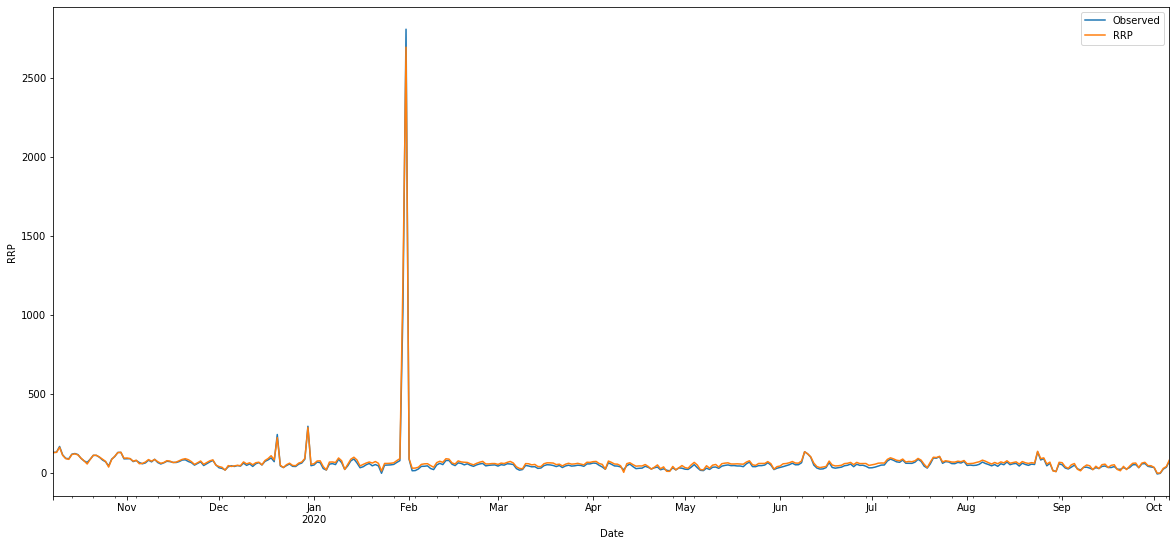

In [46]:
label_sc = StandardScaler()
label_sc.fit(df['RRP'].values.reshape(-1,1))
preds = np.concatenate(predictions, axis=0).ravel()
preds = label_sc.inverse_transform(preds)
preds = pd.DataFrame(preds,columns=["RRP"],index=X_test_xgb1.index)
plot_forecast(y_test_xgb1,preds)

**Mean absolute error of GRU model (multivariate model)**

In [47]:
mae_gru = mean_absolute_error(y_test_xgb1.values,preds.values)
print(f"The mean absolute error of GRU multivariate model is {mae_gru}")

The mean absolute error of GRU multivariate model is 9.586708278515284
